# Import Libraries:

In [4]:
# pip install xgboost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


C:\Users\HP\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\HP\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


## Load Dataset:


In [4]:
df=pd.read_csv("household_power_consumption.csv")

In [6]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


In [8]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1048575 non-null  str    
 1   Time                   1048575 non-null  str    
 2   Global_active_power    1048575 non-null  str    
 3   Global_reactive_power  1048575 non-null  str    
 4   Voltage                1048575 non-null  str    
 5   Global_intensity       1048575 non-null  str    
 6   Sub_metering_1         1048575 non-null  str    
 7   Sub_metering_2         1048575 non-null  str    
 8   Sub_metering_3         1044506 non-null  float64
dtypes: float64(1), str(8)
memory usage: 107.7 MB


### Date & Time Combine:
        -Time series forecasting mein datetime index MUST hota hai.

In [11]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('datetime', inplace=True)

df.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_14504\3871424267.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


In [13]:
#Unnecessary Columns Remove
df.drop(['Date','Time'], axis=1, inplace=True)


In [17]:
#Convert String Columns to Numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


### Handle Missing Values

In [20]:
df.isna().sum()

Global_active_power      4069
Global_reactive_power    4069
Voltage                  4069
Global_intensity         4069
Sub_metering_1           4069
Sub_metering_2           4069
Sub_metering_3           4069
dtype: int64

In [22]:
df = df.dropna()


In [24]:
df.duplicated().sum()

76678

In [26]:
df.drop_duplicates()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0
2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0


In [28]:
df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1044506 entries, 2006-12-16 17:24:00 to 2008-12-13 21:38:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1044506 non-null  float64
 1   Global_reactive_power  1044506 non-null  float64
 2   Voltage                1044506 non-null  float64
 3   Global_intensity       1044506 non-null  float64
 4   Sub_metering_1         1044506 non-null  float64
 5   Sub_metering_2         1044506 non-null  float64
 6   Sub_metering_3         1044506 non-null  float64
dtypes: float64(7)
memory usage: 63.8 MB


### Select Target Column:

In [31]:
ts = df['Global_active_power']


In [35]:
#Resample Data
#Raw data minute level hai → noisy hota hai
ts_hourly = ts.resample('h').mean()



### Visualize Time Series:

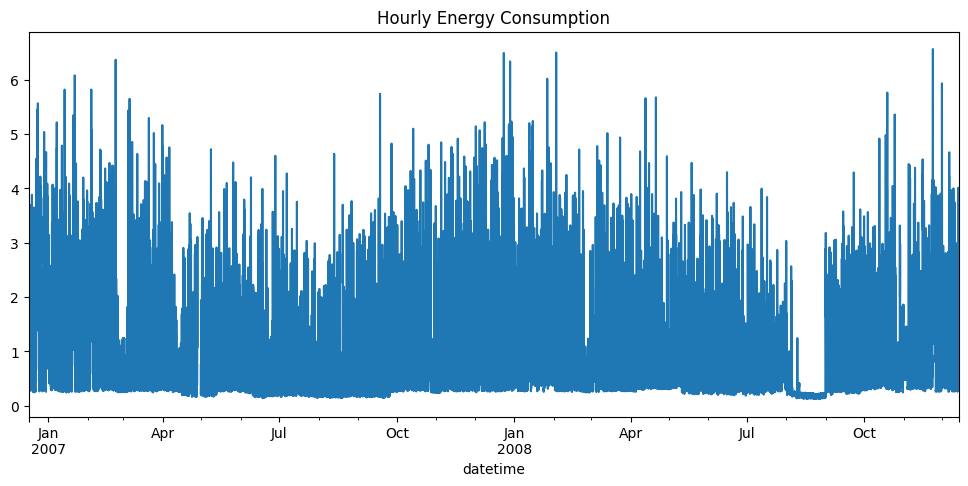

In [38]:
ts_hourly.plot(figsize=(12,5))
plt.title("Hourly Energy Consumption")
plt.show()


### Feature Engineering:

In [41]:
data = ts_hourly.to_frame()

data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month
data['weekend'] = data['dayofweek'].isin([5,6]).astype(int)

data.head()


,Global_active_power,hour,dayofweek,month,weekend
datetime,,,,,
2006-12-16 17:00:00,4.222889,17,5,12,1
2006-12-16 18:00:00,3.632200,18,5,12,1
2006-12-16 19:00:00,3.400233,19,5,12,1
2006-12-16 20:00:00,3.268567,20,5,12,1
2006-12-16 21:00:00,3.056467,21,5,12,1


### Train Test Split

In [44]:
train = data.iloc[:-168]   # Last 7 days test
test = data.iloc[-168:]


# ARIMA Model:

In [47]:
model_arima = ARIMA(train['Global_active_power'], order=(5,1,0))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.forecast(steps=len(test))


# XGBoost Model

In [97]:
#Feature Engineering
data_ml = ts_hourly.to_frame()
data_ml['hour'] = data_ml.index.hour
data_ml['dayofweek'] = data_ml.index.dayofweek
data_ml['month'] = data_ml.index.month
data_ml['weekend'] = data_ml['dayofweek'].isin([5,6]).astype(int)
#Train Test Split
train_ml = data_ml.iloc[:-168]
test_ml = data_ml.iloc[-168:]
#Prepare Features
features = ['hour','dayofweek','month','weekend']






In [99]:
data_ml.isnull().sum()


Global_active_power    62
hour                    0
dayofweek               0
month                   0
weekend                 0
dtype: int64

In [101]:
data_ml = data_ml.dropna()


In [103]:
train_ml = data_ml.iloc[:-168]
test_ml = data_ml.iloc[-168:]


In [105]:
X_train = train_ml[features]
y_train = train_ml['Global_active_power']

X_test = test_ml[features]
y_test = test_ml['Global_active_power']


In [120]:
y_test.shape

(168,)

In [128]:
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)


In [131]:
xgb_pred.shape

(168,)

### Model Evaluation

In [135]:
from sklearn.metrics import mean_squared_error
print("ARIMA RMSE:", np.sqrt(mean_squared_error(y_test, forecast_arima)))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))


ARIMA RMSE: 1.0424416919831456
XGBoost RMSE: 0.7942148185065139
